# Sidekick - Mixture of Least Squares
We train a mixture of least squares, experimenting with different number of components.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from model import LeastSquaresMixture
from math import floor

DATA_DIR = "../data/sidekick"

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples

## Load and split data

In [28]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split()

Loading projects...
Loading statuses...
Converting to project instances...
Data loaded.


## Data processing

In [29]:
N = 1000
N_train = int(floor(0.8*N))
seed = 2
t0 = 1
t1 = 500
n_samples = 25
T = 999

samples = subsample(t0, t1, n_samples)
t = len(samples)

#N_projects = sk.choose_n_projects(n=N, seed=seed)
#projects_train = N_projects[:N_train]
#projects_test = N_projects[N_train:]

#with open("../data/sidekick/light.pkl", 'wb') as f:
#    cp.dump(N_projects, f)

X_train = np.ndarray(shape=(len(projects_train), t), buffer=np.array([p.money[samples] for p in projects_train]), dtype=float) 
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train]), axis=1)
X_test = np.ndarray(shape=(len(projects_test), t), buffer=np.array([p.money[samples] for p in projects_test]), dtype=float) 
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test]), axis=1)

# Required to contain the prediction in a reasonable range
# The problem arises when evaluating the likelihood in the expression for gamma_nk
X_max = np.max(X_train, axis=0)
X_train = X_train / X_max[np.newaxis, :]
# Apply same preprocessing to testing set
X_test = X_test / X_max[np.newaxis, :]  

print("Training on %s projects" % len(X_train))
print("Testing on %s projects" % len(X_test))
print("Number of features: %s" % n_samples)

Training on 12833 projects
Testing on 3209 projects
Number of features: 25


## Train Mixture of Least Squares

### Grid Search Training

In [33]:
K = 3
epsilon = 1e-6
iterations = 1000
random_restarts = 10
betas = np.array([1/np.var(y_train)])
lambdas = np.logspace(-8, 2, 50)
k_fold = 5

mls = LeastSquaresMixture(X_train, y_train, K=K,
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
rmse_avg, rmse_std, accuracy_avg, accuracy_std = mls.grid_search(betas, lambdas, k_fold=k_fold)

print(mls)

Grid Search: [####################] 100% Elapsed time: 0:14:11
Model:        LeastSquaresMixture (3 components)
Likelihood:   -45.2796669488158
Beta:         45.41168979836561
Lambda:       4.71486636346e-05
Pi:           [ 0.54827003  0.15905906  0.29267091]
Weights norm: [60.255025492017779, 162.18004906028452, 169.83250919501722]



### Simple Training

In [38]:
K = 2
#beta = 1 / np.var(y_train)
beta = 0.0001
epsilon = 1e-2
lam = 0.01
iterations = 1000
random_restarts = 1

mls = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls.train(verbose=True)

print(mls)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = 0.0001
* Lambda = 0.01
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 0.01
Obj		pi1		pi2		w11		w12		w21		w22		beta
-70977.46	0.50	0.50	0.14	-32.57	0.14	-32.27	0.01
-43342.43	0.50	0.50	0.13	-32.78	0.14	-32.08	0.60


/Users/kristof/Documents/GitHub/gaussian-process/src/model/least_squares_mixture.py:116: RuntimeWarning: invalid value encountered in true_divide
  gamma /= np.tile(np.sum(gamma, 1), (self.K, 1)).T


ValueError: array must not contain infs or NaNs

## Evaluation

In [18]:
rmse, accuracy, chosen = mls.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (5 components)...
Data point (200/200): [####################] 100% Elapsed time: 0:00:02
Accuracy: 0.745
RMSE    : 12.2177344354
Chosen  : Counter({3: 101, 4: 43, 0: 25, 2: 17, 1: 14})


In [27]:
test = 5
x_new = X_test[test]
y_new, y_posteriors = mls.predict(x_new, posteriors=True)
print("Predicted:  %s" % y_new[0])
print("Posteriors: %s" % ["%0.2f%%" % (p * 100) for p in y_posteriors])
print("Actual:     %s" % y_test[test])

Predicted:  [  9.62317922  10.95800806  11.01867876   9.1778063    8.50069221]
Posteriors: ['0.00%', '0.00%', '100.00%', '0.00%', '0.00%']
Actual:     [ 11.01256378]


## Plots

### 0-1 Loss

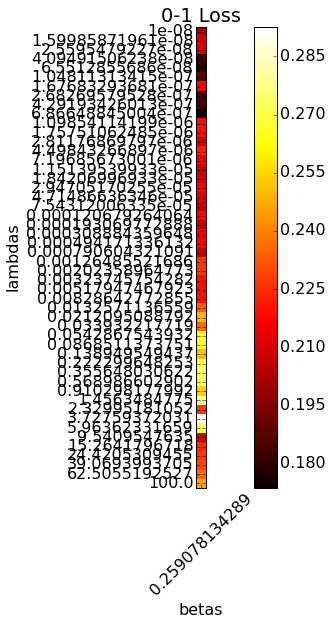

In [35]:
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(1 - np.array(accuracy_avg), interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.colorbar()
plt.xticks(np.arange(len(betas)), ["%s" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.title('0-1 Loss')
plt.show()

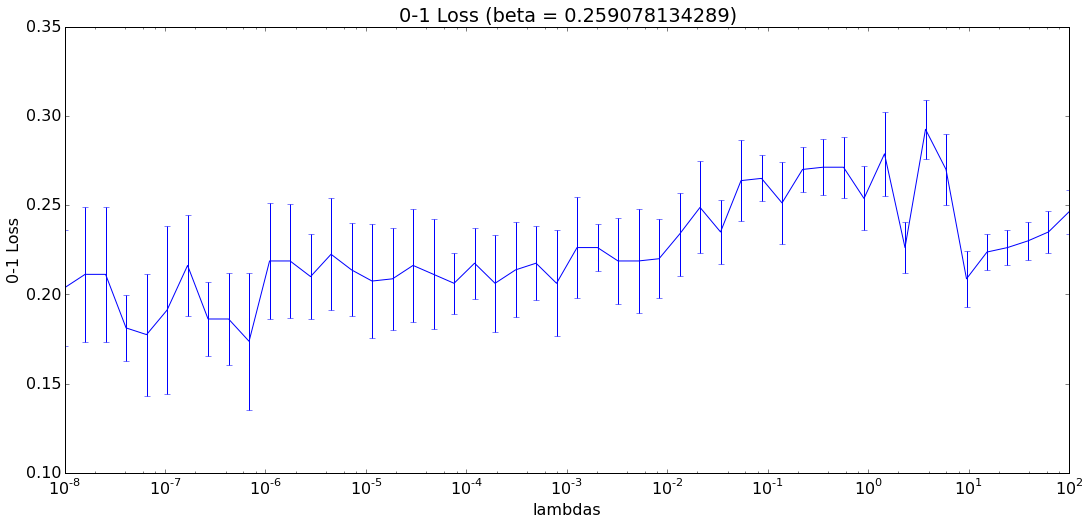

In [36]:
plt.errorbar(list(lambdas), [1-a[0] for a in accuracy_avg], yerr=[a[0] for a in accuracy_std])
plt.xscale('log')
plt.title("0-1 Loss (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("0-1 Loss")
plt.show()

### RMSE

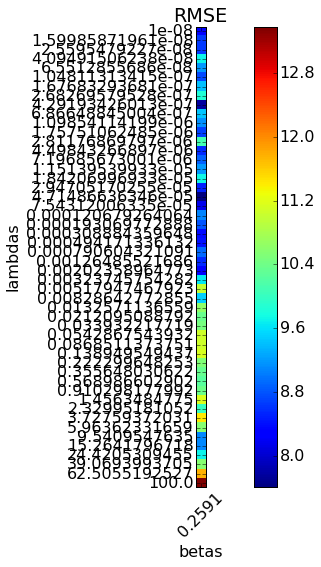

In [39]:
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(rmse_avg, interpolation='nearest')
plt.xticks(np.arange(len(betas)), ["%0.4f" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.colorbar()
plt.title('RMSE')
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.show()

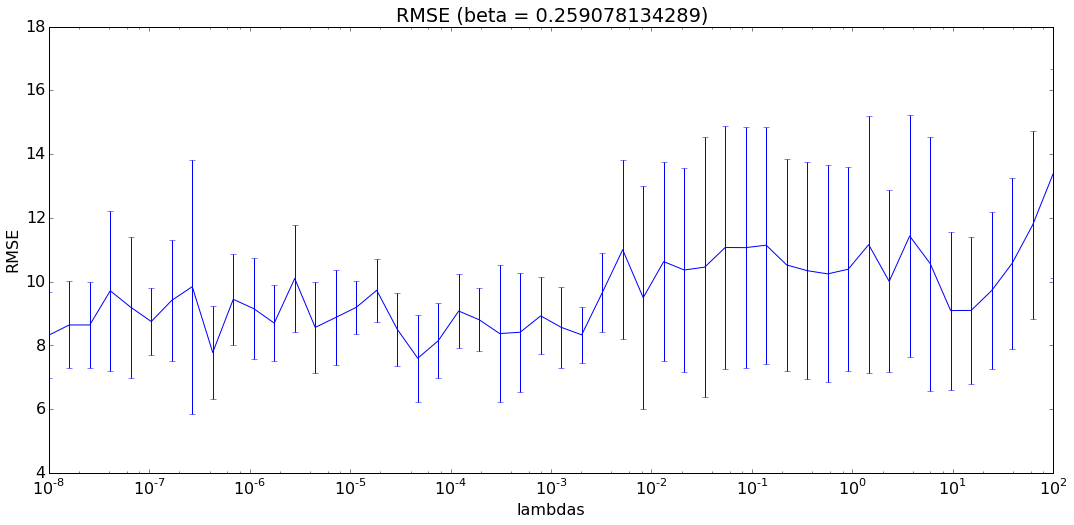

In [40]:
plt.errorbar(list(lambdas), [r[0] for r in rmse_avg], yerr=[r[0] for r in rmse_std])
plt.xscale('log')
plt.title("RMSE (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("RMSE")
plt.show()